In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /private/var/folders/sx/889jdz09109dzlhy65xnx_6m0000gn/T/pip-req-build-2z1cnge4
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /private/var/folders/sx/889jdz09109dzlhy65xnx_6m0000gn/T/pip-req-build-2z1cnge4


  Created wheel for finrl: filename=finrl-0.3.0-py3-none-any.whl size=38392 sha256=00e16450945e6173232c9806ac53f0e68085a1f0854c920351406ddc1d34196c
  Stored in directory: /private/var/folders/sx/889jdz09109dzlhy65xnx_6m0000gn/T/pip-ephem-wheel-cache-ptf5m6_x/wheels/17/ff/bd/1bc602a0352762b0b24041b88536d803ae343ed0a711fcf55e
Successfully built finrl


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/Users/alexandrubordanca/opt/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [4]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [5]:
# from config.py end_date is a string
config.END_DATE = '2021-04-01'
config.END_DATE


'2021-04-01'

In [6]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [7]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-04-01',
                     ticker_list = ['GME','AMC','SNDL']).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (5335, 8)


In [8]:
df.shape

(5335, 8)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,21.730000,23.750000,21.040001,15.613833,3490900,GME,4
1,2009-01-05,23.240000,24.490000,23.000000,16.044743,3409400,GME,0
2,2009-01-06,24.049999,24.530001,23.150000,15.836020,3466500,GME,1
3,2009-01-07,23.420000,23.420000,22.260000,15.223316,2780700,GME,2
4,2009-01-08,24.690001,26.150000,23.000000,17.223019,10538000,GME,3


In [10]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [11]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [12]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2009-01-02,AMC,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,2009-01-02,GME,21.730000,23.750000,21.040001,15.613833,3490900.0,4.0,0.000000,16.438686,15.219890,100.000000,66.666667,100.0,15.613833,15.613833,0.0
2,2009-01-02,SNDL,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,2009-01-05,AMC,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,2009-01-05,GME,23.240000,24.490000,23.000000,16.044743,3409400.0,0.0,0.009668,16.438686,15.219890,100.000000,66.666667,100.0,15.829288,15.829288,0.0
5,2009-01-05,SNDL,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
6,2009-01-06,AMC,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
7,2009-01-06,GME,24.049999,24.530001,23.150000,15.836020,3466500.0,1.0,0.005846,16.262511,15.400553,66.618654,49.550162,100.0,15.831532,15.831532,0.0
8,2009-01-06,SNDL,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
9,2009-01-07,AMC,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [13]:
train = data_split(processed_full, '2009-01-01','2019-01-01')
trade = data_split(processed_full, '2019-01-01','2021-04-01')
print(len(train))
print(len(trade))

7548
1698


In [14]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2009-01-02,AMC,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0
0,2009-01-02,GME,21.73,23.75,21.040001,15.613833,3490900.0,4.0,0.000000,16.438686,15.21989,100.0,66.666667,100.0,15.613833,15.613833,0.0
0,2009-01-02,SNDL,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0
1,2009-01-05,AMC,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0
1,2009-01-05,GME,23.24,24.49,23.000000,16.044743,3409400.0,0.0,0.009668,16.438686,15.21989,100.0,66.666667,100.0,15.829288,15.829288,0.0


In [15]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2019-01-02,AMC,12.01,13.08,11.90,11.914326,1374900.0,2.0,-0.701041,14.488310,10.680646,40.485245,-104.459928,33.866726,12.574529,14.702906,4.114957
0,2019-01-02,GME,12.45,13.18,12.42,12.641105,2124200.0,2.0,-0.280966,13.242756,11.383998,48.209291,-20.372024,2.414213,12.531562,13.170070,4.114957
0,2019-01-02,SNDL,0.00,0.00,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2019-01-03,AMC,12.80,13.54,12.63,12.071457,1392400.0,3.0,-0.641874,14.448067,10.631638,41.377001,-54.833632,22.162177,12.549945,14.604765,0.326790
1,2019-01-03,GME,12.98,13.26,12.69,12.544387,1750400.0,3.0,-0.229764,13.160574,11.416397,47.698639,-12.437444,0.450027,12.548819,13.149078,0.326790


In [16]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 3, State Space: 31


In [18]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [38]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [39]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

Logging to tensorboard_log/td3/td3_10
-----------------------------------
| environment/        |           |
|    portfolio_value  | 7.89e+05  |
|    total_cost       | 999       |
|    total_reward     | -2.11e+05 |
|    total_reward_pct | -21.1     |
|    total_trades     | 2515      |
| time/               |           |
|    episodes         | 4         |
|    fps              | 74        |
|    time_elapsed     | 135       |
|    total timesteps  | 10064     |
| train/              |           |
|    actor_loss       | -1.42e+03 |
|    critic_loss      | 1.13e+04  |
|    learning_rate    | 0.001     |
|    n_updates        | 7548      |
-----------------------------------
day: 2515, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 789134.10
total_reward: -210865.90
total_cost: 999.00
total_trades: 2515
Sharpe: 0.108
-----------------------------------
| environment/        |           |
|    portfolio_value  | 7.89e+05  |
|    total_cost       | 999       |
|    total_re

In [41]:
data_turbulence = processed_full[(processed_full.date<'2019-01-01') & (processed_full.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [42]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean        1.088331
std         5.168935
min         0.000000
25%         0.000000
50%         0.000599
75%         0.802913
max       202.293413
Name: turbulence, dtype: float64

In [43]:
#turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [44]:
#turbulence_threshold

In [45]:
trade = data_split(processed_full, '2019-01-01','2021-04-01')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold=100, **env_kwargs)

In [46]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2019-01-02,AMC,12.01,13.08,11.90,11.914326,1374900.0,2.0,-0.701041,14.488310,10.680646,40.485245,-104.459928,33.866726,12.574529,14.702906,4.114957
0,2019-01-02,GME,12.45,13.18,12.42,12.641105,2124200.0,2.0,-0.280966,13.242756,11.383998,48.209291,-20.372024,2.414213,12.531562,13.170070,4.114957
0,2019-01-02,SNDL,0.00,0.00,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2019-01-03,AMC,12.80,13.54,12.63,12.071457,1392400.0,3.0,-0.641874,14.448067,10.631638,41.377001,-54.833632,22.162177,12.549945,14.604765,0.326790
1,2019-01-03,GME,12.98,13.26,12.69,12.544387,1750400.0,3.0,-0.229764,13.160574,11.416397,47.698639,-12.437444,0.450027,12.548819,13.149078,0.326790


In [47]:
df_account_value,df_actions = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)

hit end!


In [48]:
df_account_value.shape


(566, 2)

In [49]:
df_account_value.tail()

,date,account_value
561,2021-03-25,1.929754e+06
562,2021-03-26,1.918376e+06
563,2021-03-29,1.919546e+06
564,2021-03-30,1.974884e+06
565,2021-03-31,1.954870e+06


In [50]:
df_actions.tail(50)

,AMC,GME,SNDL
date,,,
2021-01-19,0,100,100
2021-01-20,0,100,100
2021-01-21,0,100,100
2021-01-22,0,100,100
2021-01-25,0,100,100
2021-01-26,0,-5100,-5100
2021-01-27,0,0,0
2021-01-28,0,100,100
2021-01-29,0,100,100


In [51]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.347765
Cumulative returns     0.954870
Annual volatility      0.299900
Sharpe ratio           1.137298
Calmar ratio           1.503068
Stability              0.247607
Max drawdown          -0.231370
Omega ratio            1.505628
Sortino ratio          2.571673
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.478316
Daily value at risk   -0.036430
dtype: float64


In [52]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^GSPC", 
        start = '2019-01-01',
        end = '2021-04-01')

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (566, 8)
Annual return          0.226849
Cumulative returns     0.582806
Annual volatility      0.250145
Sharpe ratio           0.945021
Calmar ratio           0.668679
Stability              0.666080
Max drawdown          -0.339250
Omega ratio            1.221689
Sortino ratio          1.306961
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.719028
Daily value at risk   -0.030577
dtype: float64


==============Compare to S&P 500===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (566, 8)


Start date,2019-01-02
End date,2021-03-31
Total months,26
,Backtest
Annual return,34.777%
Cumulative returns,95.487%
Annual volatility,29.99%
Sharpe ratio,1.14
Calmar ratio,1.50
Stability,0.25
Max drawdown,-23.137%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.14,2021-03-10,2021-03-24,NaT,NaN
1,16.47,2019-01-25,2020-04-03,2020-09-17,430
2,13.32,2020-10-23,2020-10-30,2021-01-21,65
3,5.52,2021-01-29,2021-02-19,2021-02-25,20
4,4.97,2020-10-08,2020-10-12,2020-10-15,6


/Users/alexandrubordanca/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.14%,-12.20%,26.29%


/Users/alexandrubordanca/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


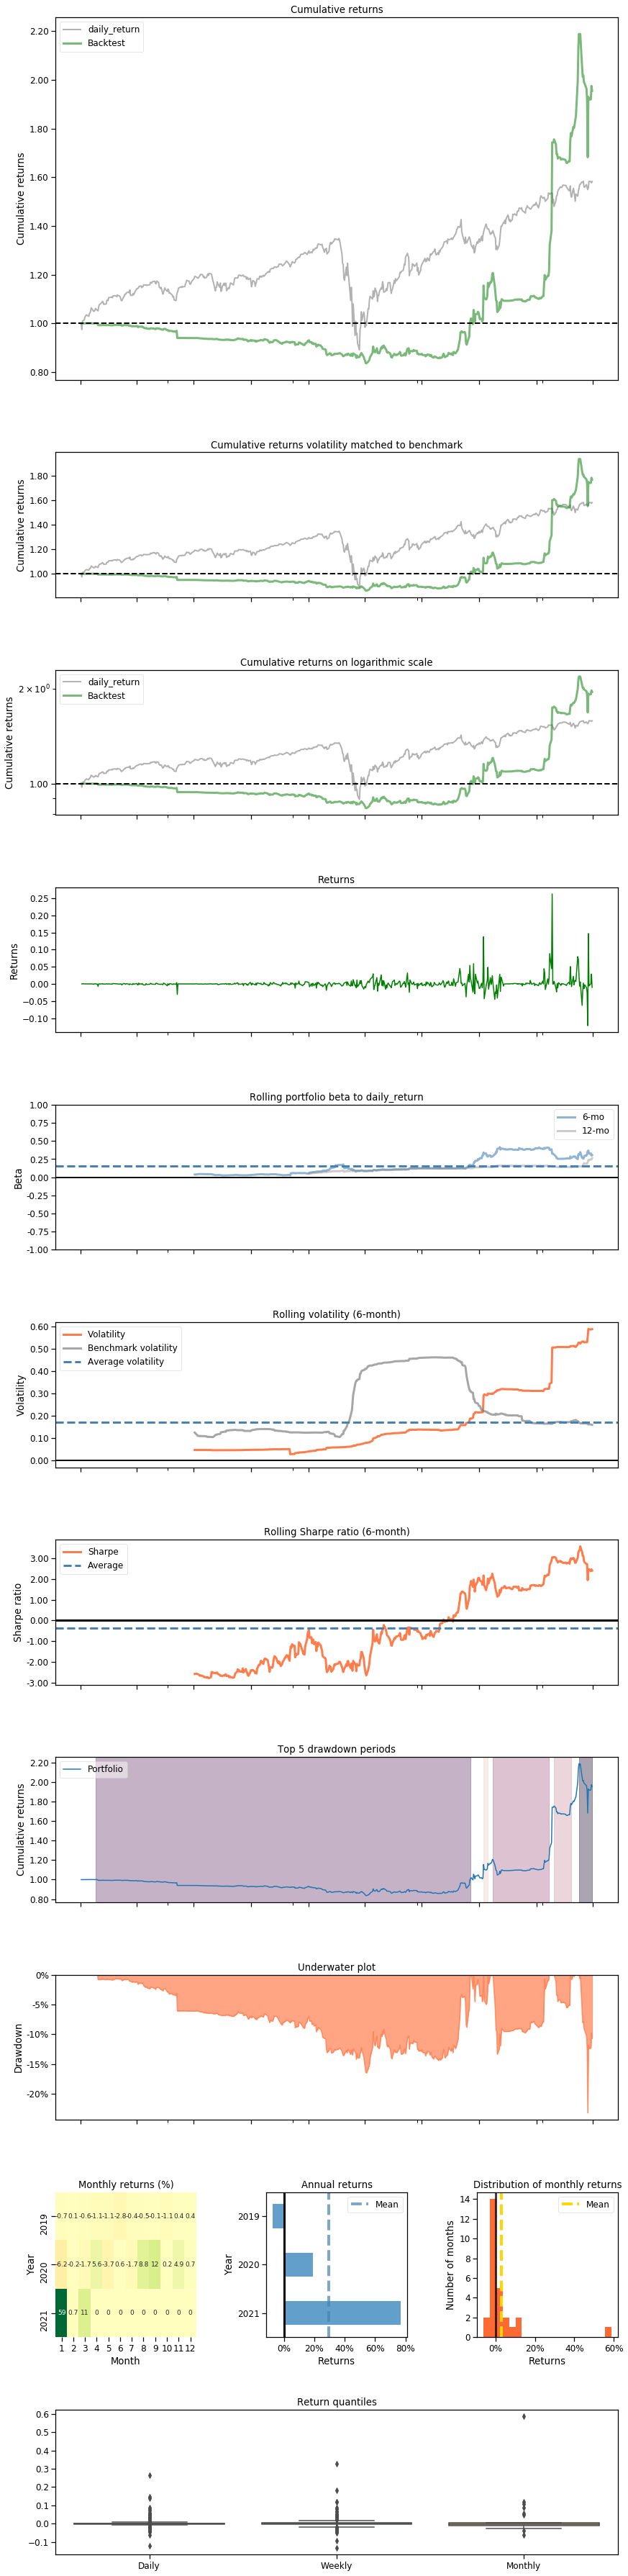

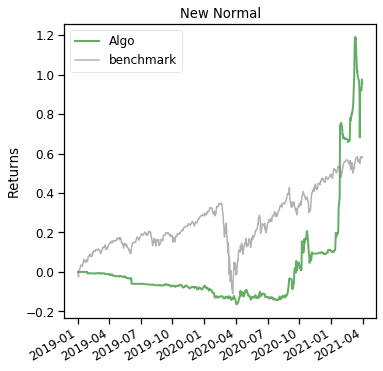

In [53]:
print("==============Compare to S&P 500===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^GSPC', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-04-01')